In [1]:
import torch
import torch.nn as nn

import json
import pickle
from tqdm import tqdm

from sklearn.metrics import precision_recall_fscore_support

In [2]:
# def create_dataset(train_or_dev):
#     file_path = f'data/{train_or_dev}.data.txt'
#     label_path = f'data/{train_or_dev}.label.txt'

#     tweet_ids = []
#     tweet_labels = []

#     with open(file_path, mode='r') as file, open(label_path, mode='r') as label_file:
#         labels = label_file.readlines()

#         for index, line in enumerate(file):
#             ids = line.strip().split(',')
#             source_id = ids[0]
#             temp_ids = []

#             try:
#                 with open(f'{train_or_dev}-data/{source_id}.json', 'r'):
#                     temp_ids.append(int(source_id))
#                     tweet_labels.append(1. if labels[index].strip() == 'rumour' else 0.)
#             except:
#                 continue
                
#             for reply_id in ids[1:]:
#                 try:
#                     with open(f'{train_or_dev}-data/{reply_id}.json', 'r'):
#                         temp_ids.append(int(reply_id))
#                 except:
#                     continue
            
#             tweet_ids.append(temp_ids)

#     return tweet_ids, tweet_labels

# train_tweet_ids, train_labels = create_dataset('train')
# dev_tweet_ids, dev_labels = create_dataset('dev')

# with open("data/dev.label.pro.txt", "w") as f:
#     for label in dev_labels:
#         f.write(f"{label}\n")

In [3]:
# with open('output/train.tfidf.pkl', 'rb') as handle:
#     train_id2tfidf = pickle.load(handle)

# with open("output/dev.tfidf.pkl", 'rb') as handle:
#     dev_id2tfidf = pickle.load(handle)

In [4]:
# import networkx as nx

# def build_graph(train_or_dev, id2vec=None):
#     file_path = f'data/{train_or_dev}.data.pro.txt'
#     label_path = f'data/{train_or_dev}.label.pro.txt'
    
#     graph = []

#     with open(file_path, mode='r') as file, open(label_path, mode='r') as label_file:
#         labels = label_file.readlines()
#         file_data = file.readlines()
        
#         print(len(labels), len(file_data))

#         for index, line in enumerate(tqdm(file_data)):
#             tweet_ids = [int(t_id) for t_id in line.strip().split(',')]
#             source_id = tweet_ids[0]

#             try:
#                 with open(f'{train_or_dev}-data/{source_id}.json', 'r'):
#                     pass
#             except:
#                 # the source tweet is not in the dataset, just skip it
#                 continue

#             dg = nx.DiGraph()
#             for tweet_id in tweet_ids:
#                 try:
#                     with open(f'{train_or_dev}-data/{tweet_id}.json', 'r') as json_data:
#                         tweet = json.load(json_data)
#                         parent_tweet = tweet['in_reply_to_status_id'] # int or none
#                         dg.add_node(tweet_id)
#                         if parent_tweet is not None and parent_tweet in tweet_ids:
#                             dg.add_edge(tweet_id, parent_tweet) # tweet_id -> parent_tweet
#                 except:
#                     continue

#             # remove the edges that are not connected to the source tweet
#             s = dg.subgraph(nx.shortest_path(dg.to_undirected(), source_id))
#             # get topological order
#             topological_order = [generation for generation in nx.topological_generations(s)]
#             # find the successors of each nodes in the graph
#             parent2child = {n: list(s.predecessors(n)) for n in list(s.nodes)}

#             inputs = {}
#             for node in s.nodes():
#                 # with open(f'embeddings/{train_or_dev}/content/{train_or_dev}/{tweet_id}', 'rb') as f:
#                 #     inputs[node] = torch.Tensor(pickle.load(f))
#                 inputs[node] = torch.Tensor(id2vec[node])
            
#             # append them into the graph 
#             # is_rumour = 1. if labels[index].strip() == 'rumour' else 0.
#             graph.append((topological_order, parent2child, inputs, float(labels[index])))
        
#     return graph


# # with open('output/train_tweet_embedding_768.pkl', 'rb') as handle:
# #     train_id2vec = pickle.load(handle)

# # with open("output/dev_tweet_embedding_768.pkl", 'rb') as handle:
# #     dev_id2vec = pickle.load(handle)

# train_graph = build_graph('train', train_id2tfidf) #, train_id2vec)  
# dev_graph = build_graph('dev', dev_id2tfidf) #, dev_id2vec)  

# with open(f"output/train_graph_tfidf.pkl", 'wb') as out:
#     pickle.dump(train_graph, out, pickle.HIGHEST_PROTOCOL)

# with open(f"output/dev_graph_tfidf.pkl", 'wb') as out: 
#     pickle.dump(dev_graph, out, pickle.HIGHEST_PROTOCOL)

In [5]:
with open('output/train_graph_tfidf.pkl', 'rb') as handle:
    train_graph = pickle.load(handle)

with open("output/dev_graph_tfidf.pkl", 'rb') as handle:
    dev_graph = pickle.load(handle)

print(len(train_graph))
print(len(dev_graph))

1561
534


In [6]:
# with open('output/train_tweet_embedding_100.pkl', 'rb') as handle:
#     train_id2vec = pickle.load(handle)

# with open("output/dev_tweet_embedding_100.pkl", 'rb') as handle:
#     dev_id2vec = pickle.load(handle)

In [7]:
class TweetGraphDataset(torch.utils.data.Dataset):
    def __init__(self, graph):
        self.graph = graph
    
    def __len__(self):
        return len(self.graph)

    def __getitem__(self, index):
        return self.graph[index]

In [8]:
train_set = TweetGraphDataset(train_graph)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=True)

dev_set = TweetGraphDataset(dev_graph)
dev_loader = torch.utils.data.DataLoader(dev_set, batch_size=1)

In [9]:
class RecursiveTreeUnit(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(RecursiveTreeUnit, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        
        self.E = nn.Linear(input_dim, hidden_dim)
        self.Wr = nn.Linear(hidden_dim, hidden_dim)
        self.Ur = nn.Linear(hidden_dim, hidden_dim)
        self.Wz = nn.Linear(hidden_dim, hidden_dim)
        self.Uz = nn.Linear(hidden_dim, hidden_dim)
        self.Wh = nn.Linear(hidden_dim, hidden_dim)
        self.Uh = nn.Linear(hidden_dim, hidden_dim)

        self.dropout = nn.Dropout(0.5)

    def forward(self, node, children):
        x_j_tilde = self.E(self.dropout(node)) # 1, hidden_dim
        
        if len(children) == 0:
            z_j = torch.sigmoid(self.Wz(x_j_tilde))
            h_j_tilde = torch.tanh(self.Wh(x_j_tilde))
            h_j = z_j * h_j_tilde 
            return h_j

        processed_children = []
        for c_n in children:
            if c_n.size()[1] == self.input_dim:
                x_tilde = self.E(self.dropout(c_n))
                # rj = torch.sigmoid(self.Wr(x_tilde))
                zj = torch.sigmoid(self.Wz(x_tilde))
                hj_tilde = torch.tanh(self.Wh(x_tilde))
                hj = zj * hj_tilde
                processed_children.append(hj)
            elif c_n.size()[1] == self.hidden_dim:
                processed_children.append(c_n)

        h_S = torch.stack(processed_children, dim=0) # batch_size, hidden_dim
        h_S = h_S.sum(dim=0) # 1, hidden_dim
        
        r_j = torch.sigmoid(self.Wr(x_j_tilde) + self.Ur(h_S))
        z_j = torch.sigmoid(self.Wz(x_j_tilde) + self.Uz(h_S))
        h_j_tilde = torch.tanh(self.Wh(x_j_tilde) + self.Uh(h_S * r_j))
        h_j = (1 - z_j) * h_S + z_j * h_j_tilde

        return h_j

In [10]:
class RecursiveTree(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(RecursiveTree, self).__init__()

        self.tree_unit = RecursiveTreeUnit(input_dim, hidden_dim)
        self.linear = nn.Linear(hidden_dim, 1)
        # self.dropout = nn.Dropout(0.5)

    def forward(self, topological_order, parent2child, inputs):
        encoded_nodes = {}

        for i, nodes in enumerate(topological_order):
            # for all the leave nodes in the tree
            if i == 0:
                for node in nodes:
                    encoded_nodes[node.item()] = inputs[node.item()]
            else:
                for node in nodes:
                    encoded_nodes[node.item()] = self.tree_unit(inputs[node.item()], [encoded_nodes[child.item()] for child in parent2child[node.item()]])
        
        # if topological_order only contains one node
        if len(topological_order) == 1:
            node = topological_order[0][0]
            encoded_nodes[node.item()] = self.tree_unit(inputs[node.item()], [])

        root = encoded_nodes[topological_order[-1][0].item()]
        
        logits = self.linear(root)

        return logits

In [11]:
# batch = next(iter(train_loader))
# # print("parent2child", parent2child.keys())
# clf = RecursiveTree(6000, 64)
# # print(batch[0])
# clf(batch[0], batch[1], batch[2])

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = RecursiveTree(input_dim=6000, hidden_dim=256).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

In [13]:
def move_to(obj, device):
  if torch.is_tensor(obj):
    return obj.to(device)
  elif isinstance(obj, dict):
    res = {}
    for k, v in obj.items():
      res[k] = move_to(v, device)
    return res
  elif isinstance(obj, list):
    res = []
    for v in obj:
      res.append(move_to(v, device))
    return res
  else:
    raise TypeError("Invalid type for move_to")

In [14]:
# import time
# LOG_INTERVAL = 500

def train(model, criterion, optimizer, train_loader, dev_loader, n_epochs, device):
    train_loss, train_acc, val_loss, val_acc = list(), list(), list(), list()
    best_acc = 0
    # start_time = time.time()

    for epoch in range(1, n_epochs + 1):
        print(f"\nEpoch {epoch}/{n_epochs}")
        model.train()
        
        epoch_loss = []
        # epoch_acc = []
        y_true = []
        y_pred = []

        for it, batch in enumerate(train_loader):
            topological_order, parent2child, inputs, labels = batch
            
            topological_order = move_to(topological_order, device)
            parent2child = move_to(parent2child, device)
            inputs = move_to(inputs, device)
            label = move_to(labels, device)

            logits = model(topological_order, parent2child, inputs)

            # accuracy = get_accuracy_from_logits(logits, label)

            loss = criterion(logits.squeeze(-1), label)

            loss.backward()

            epoch_loss.append(loss.item())
            
            y_true.append(label.item())
            probs = torch.sigmoid(logits.unsqueeze(-1))
            soft_probs = (probs > 0.5).long()
            y_pred.append(soft_probs.item())

            if it % 32 == 0 and it > 0:
                optimizer.step()
                optimizer.zero_grad()

            # if it % LOG_INTERVAL == 0 and it > 0: 
            #     deltaT = time.time() - start_time
            #     mean_loss = sum(epoch_loss) / (it+1)
            #     mean_acc = sum(epoch_acc) / (it+1)
            #     print(f'[TRAIN] Epoch {epoch} [{it}/{len(train_loader)}]| Mean loss {mean_loss:.4f} | Train accuracy {mean_acc:.5f} | Time {deltaT:.2f} s')
            #     start_time = time.time()

        # train_f1 = f1_score(y_true, y_pred, pos_label=1, average="binary", zero_division=0)
        train_p, train_r, train_f, _ = precision_recall_fscore_support(y_true, y_pred, pos_label=1, average="binary", zero_division=0)
        train_epoch_loss = sum(epoch_loss) / len(epoch_loss)
        # train_epoch_acc = sum(epoch_acc) / len(epoch_acc)
        train_loss.append(train_epoch_loss)
        train_acc.append(train_f)
        
        print(f'[TRAIN] Epoch {epoch} | loss {train_epoch_loss:.4f} | f1 {train_f:.4f} | p {train_p:.4f} | r {train_r:.4f}')

        p, r, f, dev_loss = evaluate(model, criterion, dev_loader, device)
        val_loss.append(dev_loss)
        val_acc.append(f)

        print(f'[DEV] Epoch {epoch} | loss {dev_loss:.4f} | f1 {f:.4f} | p {p:.4f} | r {r:.4f}') 
        if f > best_acc:
            print(f"[SAVE] Best dev f1 improved from {best_acc:.4f} to {f:.4f}, saving model...")
            best_acc = f
            torch.save(model.state_dict(), 'models/best_f1.mdl')

    return train_loss, train_acc, val_loss, val_acc

In [15]:
# def get_accuracy_from_logits(logits, labels):
#     probs = torch.sigmoid(logits.unsqueeze(-1))
#     soft_probs = (probs > 0.5).long()
#     acc = (soft_probs.squeeze() == labels).float().mean()
#     return acc

def evaluate(model, criterion, dataloader, device):
    model.eval()

    mean_loss = []
    y_true = []
    y_pred = []

    with torch.no_grad():
        for batch in dataloader:
            topological_order, parent2child, inputs, labels = batch

            topological_order = move_to(topological_order, device)
            parent2child = move_to(parent2child, device)
            inputs = move_to(inputs, device)
            label = move_to(labels, device)
            
            logits = model(topological_order, parent2child, inputs)
            mean_loss.append(criterion(logits.squeeze(-1), label).item())

            y_true.append(label.item())
            probs = torch.sigmoid(logits.unsqueeze(-1))
            soft_probs = (probs > 0.5).float()
            y_pred.append(soft_probs.item())

    p, r, f, _ = precision_recall_fscore_support(y_true, y_pred, pos_label=1, average="binary", zero_division=0)
    return p, r, f, sum(mean_loss) / len(mean_loss)

In [16]:
num_epoch = 10

train_loss, train_acc, val_loss, val_acc = train(model, criterion, optimizer, train_loader, dev_loader, num_epoch, device)


Epoch 1/10
[TRAIN] Epoch 1 | loss 0.4589 | f1 0.5068 | p 0.5455 | r 0.4732
[DEV] Epoch 1 | loss 0.3561 | f1 0.7255 | p 0.8315 | r 0.6435
[SAVE] Best dev f1 improved from 0.0000 to 0.7255, saving model...

Epoch 2/10
[TRAIN] Epoch 2 | loss 0.1813 | f1 0.8581 | p 0.8885 | r 0.8297
[DEV] Epoch 2 | loss 0.2928 | f1 0.7783 | p 0.8977 | r 0.6870
[SAVE] Best dev f1 improved from 0.7255 to 0.7783, saving model...

Epoch 3/10
[TRAIN] Epoch 3 | loss 0.0864 | f1 0.9071 | p 0.9218 | r 0.8927
[DEV] Epoch 3 | loss 0.3122 | f1 0.7907 | p 0.8500 | r 0.7391
[SAVE] Best dev f1 improved from 0.7783 to 0.7907, saving model...

Epoch 4/10
[TRAIN] Epoch 4 | loss 0.0767 | f1 0.9459 | p 0.9550 | r 0.9369
[DEV] Epoch 4 | loss 0.2589 | f1 0.8198 | p 0.8505 | r 0.7913
[SAVE] Best dev f1 improved from 0.7907 to 0.8198, saving model...

Epoch 5/10
[TRAIN] Epoch 5 | loss 0.0688 | f1 0.9451 | p 0.9406 | r 0.9495
[DEV] Epoch 5 | loss 0.4596 | f1 0.7525 | p 0.8736 | r 0.6609

Epoch 6/10
[TRAIN] Epoch 6 | loss 0.0581 

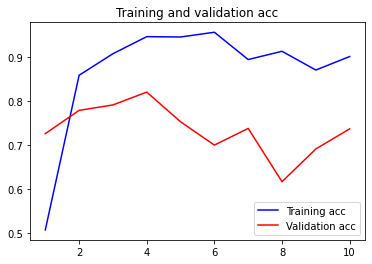

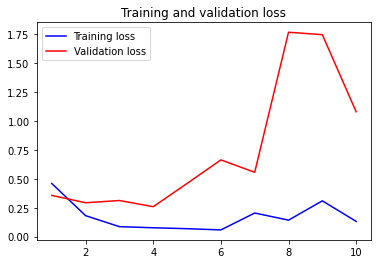

In [17]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation acc')
plt.legend()

plt.figure()

plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()